<a href="https://colab.research.google.com/github/nyongja/basic-of-reinforcement-learning/blob/main/Double_Dueling_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install tensorflow==1.14

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## 게임 환경 로딩
환경을 로딩하고 설정하는 코드.  
그리으듸 크기는 자유롭게 조절할 수 있음.  
크기를 작게 하면 DQN 에이전트가 더 쉽게 작업을 수행할 것이며, 반대로 크게 하면 어려움이 배가 될 것임. 

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]

Saving gridworld.py to gridworld (1).py


In [ ]:
open('gridworld.py','wb').write(src)

4353

In [ ]:
!pip install scipy==1.1.0

다음 그림은 환경 로딩 후 시작 환경의 예시.  
에이전트는 파란색 블록을 위, 아래, 왼쪽, 오른쪽으로 이동함.  
빨간색 블록(보상 - 1)을 피하여 초록색 블록(보상 + 1)에 도달해야 함.  
세 가지 블록의 위치는 매 에피소드마다 랜덤하게 변함

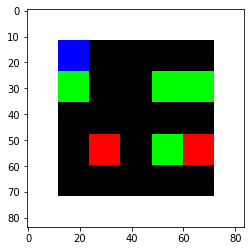

In [ ]:
from gridworld import gameEnv

env = gameEnv(partial = False, size = 5)

## 네트워크 만들기

In [ ]:
class QNetwork() :
  def __init__(self, h_size) :
    # 네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만듦(flattening)
    # 그 다음 배열의 크기를 재조절하고 4개의 합성곱 계층을 거쳐 처리한다.

    self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
    self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
    self.conv1 = slim.conv2d( \
        inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
    self.conv2 = slim.conv2d( \
        inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
    self.conv3 = slim.conv2d( \
        inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
    self.conv4 = slim.conv2d( \
        inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
    
    # 마지막 합성곱 계층에서 출력값을 취한 후
    # 이를 어드밴티지 스트림과 가치 스트림으로 분리
    self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
    self.streamA = slim.flatten(self.streamAC)
    self.streamV = slim.flatten(self.streamVC)
    xavier_init = tf.contrib.layers.xavier_initializer()
    self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
    self.VW = tf.Variable(xavier_init([h_size//2,1]))
    self.Advantage = tf.matmul(self.streamA,self.AW)
    self.Value = tf.matmul(self.streamV,self.VW)
    
    # 최종 Q 값을 얻기 위해 어드밴티지 스트림과 가치 스트림을 조합한다.
    self.Qout = self.Value + tf.subtract(self.Advantage,
                                         tf.reduce_mean(self.Advantage, axis = 1, keep_dims = True))
    self.predict = tf.argmax(self.Qout, 1)

    # 타깃 Q값과 예측 Q값의 차의 제곱합을 구함으로써 비용을 얻는다.
    self.targetQ = tf.placeholder(shape = [None], dtype = tf.float32)
    self.actions = tf.placeholder(shape = [None], dtype = tf.int32)
    self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype = tf.float32)

    self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis = 1)

    self.td_error = tf.square(self.targetQ - self.Q)
    self.loss = tf.reduce_mean(self.td_error)
    self.trainer = tf.train.AdamOptimizer(learning_rate = 0.0001)
    self.updateModel = self.trainer.minimize(self.loss)

## 경험 리플레이

경험과 샘플을 저장하고 랜덤하게 네트워크를 학습시킴.

In [ ]:
class experience_buffer() :
  def __init__(self, buffer_size = 50000) :
    self.buffer = []
    self.buffer_size = buffer_size
  
  def add(self,experience) :
    if len(self.buffer) + len(experience) >= self.buffer_size :
      self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
    self.buffer.extend(experience)

  def sample(self, size) :
    return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

다음은 게임의 프레임의 크기를 재조절해주는 간단한 함수.

In [ ]:
def processState(states) :
  return np.reshape(states, [21168])

다음 함수들은 1차 네트워크의 매개변수에 맞춰 타깃 네트워크의 매개변수를 업데이트하게 해줌.

In [ ]:
def updateTargetGraph(tfVars,tau):
  total_vars = len(tfVars)
  op_holder = []
  for idx,var in enumerate(tfVars[0:total_vars//2]):
      op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
  return op_holder

def updateTarget(op_holder, sess) :
  for op in op_holder :
    sess.run(op)

## 네트워크 학습

학습 매개변수를 설정하는 코드

In [ ]:
batch_size = 32 # 각 학습 단계에서 사용할 경험 배치의 수
update_freq = 4 # 학습 단계 업데이트 빈도
y = .99 # 타깃 Q 값에 대한 할인 계수
startE = 1 # 랜덤한 액션을 시작할 가능성
endE = 0.1 # 랜덤한 액션을 끝낼 가능성
anneling_steps = 10000 # startE에서 endE로 줄어도는 데 필요한 학습 단계 수
num_episodes = 10000 # 네트워크를 학습시키기 위한 게임 환경 에피소드의 수
pre_train_steps = 10000 # 학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50 # 허용되는 최대 에피소드 길이
load_model = False # 저장된 모델을 로드할지 여부
path = "./dqn" # 모델을 저장할 경로
h_size = 512 # 어드밴티지/가치 스트림으로 분리되기 전 마지막 합성곱 계층의 크기
tau = 0.001 # 타깃 네트워크를 제 1 네트워크로 업데이트하는 비율

학습 과정을 구현한 코드는 다음과 같음

In [ ]:
tf.reset_default_graph()
mainQN = QNetwork(h_size)
targetQN = QNetwork(h_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)
myBuffer = experience_buffer()

# 랜덤 액션이 감소하는 비율을 설정
e = startE
stepDrop = (startE - endE) / anneling_steps

# 보상의 총계와 에피소드별 단계 수를 담을 리스트를 생성함
jList = []
rList = []
total_steps = 0

# 모델을 저장할 경로를 생성함.
if not os.path.exists(path) :
  os.makedirs(path)

with tf.Session() as sess :
  sess.run(init)
  if load_model == True :
    prijnt('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess, ckpt.model_checkpoint_path)

  # 타깃 네트워크가 제 1 네트워크와 동일하도록 설정
  updateTarget(targetOps, sess)
  for i in range(num_episodes) :
    episodeBuffer = experience_buffer()
    # 환경을 리셋하고 첫 번쨰 새로은 관찰을 얻는다.
    s = env.reset()
    s = processState(s)
    d = False
    rAll = 0
    j = 0
   # Q 네트워크
   # 에이전트가 블록에 도달하기까지 최대 50회 시도하고 종료
    while j < max_epLength :
      j += 1 
      # Q 네트워크에서 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택
      if np.random.rand(1) < 3 or total_steps < pre_train_steps :
        a = np.random.randint(0, 4)
      else :
        a = sess.run(mainQN.predict, feed_dict = {mainQN.scalarInput : [s]})[0]
      s1, r, d = env.step(a)
      s1 = processState(s1)
      total_steps += 1
      # 에피소드 버퍼에 경험을 저장
      episodeBuffer.add(np.reshape(np.array([s, a, r, s1, d]), [1, 5]))

      if total_steps > pre_train_steps :
        if e > endE :
          e -= stepDrop

        if total_steps % (update_freq) == 0 :
          # 경험에서 랜덤하게 배치 하나를 샘플링
          trainBatch = myBuffer.sample(batch_size)
          # 타깃 Q 값에 대해 더블 DQN 업데이트를 수행
          Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
          Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
          end_multiplier = -(trainBatch[:,4] - 1)
          doubleQ = Q2[range(batch_size),Q1]
          targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
          # 타깃 값을 이용해 네트워크를 업데이트
          _ = sess.run(mainQN.updateModel, 
                        feed_dict = {mainQN.scalarInput : np.vstack(trainBatch[:, 0]), 
                                    mainQN.targetQ : targetQ, mainQN.actions : trainBatch[:, 1]})
          
          # 타깃 네트워크가 제 1 네트워크와 동일하도록 설정
          updateTarget(targetOps, sess)

      rAll += r
      s = s1

      if d == True :
        break
    myBuffer.add(episodeBuffer.buffer)
    jList.append(j)
    rList.append(rAll)
    # 정기적으로 모델 저장
    if i % 1000 == 0 :
      saver.save(sess, path + '/model-' + str(i) + '.cptk')
      print("Saved Model")
    if len(rList) % 10 == 0 :
      print(total_steps, np.mean(rList[-10 :]), e)

  saver.save(sess, path + '/model-' + str(i) + '.cptk')
print("Percent of succesful episodes : " + str(sum(rList) / num_episodes))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Saved Model
500 2.2 1
1000 2.3 1
1500 1.6 1
2000 2.2 1
2500 2.8 1
3000 1.8 1
3500 2.1 1
4000 1.3 1
4500 1.5 1
5000 1.9 1
5500 3.4 1
6000 1.9 1
6500 3.2 1
7000 2.1 1
7500 1.9 1
8000 0.5 1
8500 2.2 1
9000 2.2 1
9500 0.9 1
10000 2.1 1
10500 3.0 0.9549999999999828
11000 1.9 0.9099999999999655
11500 2.1 0.8649999999999483
12000 1.7 0.819999999999931
12500 2.7 0.7749999999999138
13000 1.6 0.7299999999998965
13500 2.4 0.6849999999998793
14000 1.7 0.639999999999862
14500 2.0 0.5949999999998448
15000 1.4 0.5499999999998275
15500 3.5 0.5049999999998103
16000 2.7 0.4599999999998177
16500 2.2 0.41499999999982823
17000 2.4 0.36999999999983874
17500 2.7 0.32499999999984924
18000 1.6 0.27999999999985975
18500 1.6 0.23499999999986562
19000 2.3 0.18999999999986225
19500 2.0 0.14499999999985888
20000 1.1 0.09999999999985551
20500 1.5 0.09999999999985551
21000 2.2 0.09999999999985551
21500 1.1 0.09999999999985551
22000 1.5 0.09999999999985551
22500 3.4 0.09999999999985551
23000 0.8 0.09999999999985551
23

In [ ]:
rMat = np.resize(np.array(rList), [len(rList) // 100, 100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

NameError: ignored